# Reverse Docking
This pipeline executes a Reverse Docking protocol by taking a comma-separated list of PDB codes as input. It utilizes the GOLD docking software to dock a specific ligand into various PDB structures. The binding site is determined in two ways - if a ligand has already been crystallized, the binding site is selected within an 8 Angstrom radius of it. However, if there is no available crystal ligand, the hit compound is docked into all available protein binding sites using the CCDC Cavity module.

If there are multiple crystal ligands, the software cannot select the best pocket and will dock the ligand in all available pockets. After the docking process is complete, the pipeline retrieves crucial protein data from Uniprot using the ID Mapping function.

To minimize noise generated by the docking protocol, an unsupervised Machine Learning algorithm (K-Means) is applied to cluster the poses based on CCDC GOLD scores and the number of H-Bonds. The pipeline utilizes the maximum number of available cores, but adjustments may be necessary for HPC usage.

## Settings
- Environment variable of the CSD home directory and GOLD home directory must be set
- A TXT file called "PDB_codes.txt" (comma separated list of PBD) must be provided and be stored in a folder called *proteins*
- The ligand *must* have the name "ligand.sdf" and must be in the working directory
- The number of clusters must be changed in order to be compliance with the ElbowRule and Silhouette Score

## Infos
- This example uses the GoldScore and PLP score functions.
- The code take into account also the H-Bonds
- The protocol is vulnerable to high noise levels caused by ligands being docked into unrealistic binding sites. To mitigate this noise, the cluster methodology plays a crucial role.
- Selecting appropriate PDB structures is the most critical operation.
- All the poses for each cavity are stored inside a file called *_merged.mol2
- A CSV file will be saved for each crucial passage in order to further analyse the results

## Possible Bugs
- If the Uniprot ID mapping process is not completed, the retrieval process will fail.
- If you add a unreal PDB code inside the file "PDB_codes.txt", nothing will be fetched

In [1]:
import os
os.environ['CSDHOME'] = '/home/hitesit/CCDC/CSD_2022'
os.environ["GOLD_DIR"] = "/home/hitesit/CCDC/Discovery_2022/GOLD"

In [ ]:
import os, shutil, re, glob

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ccdc.docking import Docker
from ccdc import io
from ccdc.io import EntryWriter
from ccdc.cavity import Cavity
from ccdc import conformer
from ccdc.protein import Protein

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import multiprocessing
from multiprocessing import Pool

import sys
sys.path.append(os.path.abspath("./proteins"))
from fetch_proteins import fetch_proteins

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Fetch the proteins from the PDB text file and put everything into the proteins directory
fetch_proteins("./proteins", None)

7RMH has no organic
7RMI has no organic
Out of: 16 only 14 had cristal ligand


In [4]:
# Grab the input names
proteins = glob.glob("./proteins/*.pdb")
ligand_filename = "ligand.sdf"

### Prepare Ligand

In [5]:
def prepare_ligand(lig_mol2):

    lig_basename = lig_mol2.split(".")[0]

    ligand_prep = Docker.LigandPreparation()

    ligand_prep.settings.add_hydrogens = True

    mol_reader = io.MoleculeReader(lig_mol2)
    mol = mol_reader[0]
    conformer_generator = conformer.ConformerGenerator()
    conformer_generator.settings.max_conformers = 200
    conformer_generator.settings.superimpose_conformers_onto_reference = True

    conformers = conformer_generator.generate(mol)
    conformers_mols = [c.molecule for c in conformers]
    most_probable_conformer = conformers_mols[0]
    
    io.MoleculeWriter(f"{lig_basename}_prepared.mol2").write(most_probable_conformer)

    output = lig_basename + "_prepared.mol2"

    return output

In [6]:
lig_prep_filename = prepare_ligand(ligand_filename)

INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul


### Prepare Protein

In [7]:
def define_pocket_cristal(protein_file):
    '''
    This is a Python function called "define_pocket". It takes a single argument, "protein_file", which is the file path of a protein file in PDB format.
    The purpose of this function is to identify protein cavities within the input file and extract the residues within each cavity.
    '''
    protein_cavity = Cavity.from_pdb_file(protein_file)

    lig_cavities = []
    for num in range(0,20):
        try:
            lig = protein_cavity[num].ligands
            for l in lig:
                if l.identifier:
                    lig_cavity = protein_cavity[num]
                    lig_cavities.append(lig_cavity)
                    #print(f"ligand found in pocket {num}")
                    #print(f"ligand is {l.identifier}")
        except:
            pass
    
    residue_dict = {}
    for num, cavity in enumerate(lig_cavities):

        residues = []
        for num2 in range(0,200):
            try:
                res = cavity.features[num2].residue
                residues.append(res)
            except:
                pass

        residue_dict[num] = residues

    return residue_dict

In [8]:
def define_pocket(protein_file):
    '''
    This is a Python function called "define_pocket". It takes a single argument, "protein_file", which is the file path of a protein file in PDB format.
    The purpose of this function is to identify protein cavities within the input file and extract the residues within each cavity.
    '''
    protein_cavity = Cavity.from_pdb_file(protein_file)
    pdb = Protein.from_file(protein_file)

    residues_dict = {}
    for num in range(0,200):
        try:
            cavity = protein_cavity[num]
        except:
            break

        residues = []
        for num2 in range(0,200):
            try:
                res = cavity.features[num2].residue
                residues.append(res)
            except:
                pass
        
        residues_dict[num] = residues

    return residues_dict

In [9]:
def clean_protein(param):
    '''
    This is a Python function called "clean_protein". It takes a single argument, "param", which is a tuple containing the file path of a protein file in PDB format and the file path of a ligand file in mol2 format.
    The purpose of this function is to remove all ligands from the protein file and save the cleaned protein file in a new directory.
    '''
    protein_file = param[0]
    ligand_file = param[1]

    # Get the basename of the input protein file
    temp = os.path.basename(protein_file)
    protein_basename = temp.split(".")[0]

    # Load the protein file, remove water and unknown atoms, and add hydrogens
    prot_entry = Protein.from_file(protein_file)
    prot_entry.remove_all_waters()
    prot_entry.remove_unknown_atoms()
    prot_entry.add_hydrogens()
    prot_entry.sort_atoms_by_residue()

    lig_prot = prot_entry.ligands

    # Remove ligands from the protein and create a new directory to save the cleaned protein file
    for l in lig_prot:
        prot_entry.remove_ligand(l.identifier)
        
    os.makedirs(protein_basename, exist_ok=True)

    # Write the cleaned protein file to the new directory
    protein_prepared = os.path.join(protein_basename, f"{protein_basename}_clean.pdb")
    
    with EntryWriter(protein_prepared) as writer:
        writer.write(prot_entry)
    
    # Copy the ligand in each folder
    shutil.copy(ligand_file, protein_basename)

In [10]:
num_cpu = multiprocessing.cpu_count()

if __name__ == '__main__':

    param = [(protein, lig_prep_filename) for protein in proteins]
    
    with Pool(num_cpu) as p:
        p.map(clean_protein, param)

In [11]:
# Os walk to get all the protein files (clean) in the directory
proteins_cleaned = []
for root, dirs, files in os.walk("./"):
    for file in files:
        if file.endswith("clean.pdb"):
            proteins_cleaned.append(os.path.join(root, file))

### Run Docking

In [12]:
def docker_io(protein, protein_cleaned, ligand_prep, lig_entry_pocket, pocket):
    '''
    This is a Python function called "docker_io". It takes four arguments, "protein", "protein_cleaned", "ligand_prep", and "lig_entry_pocket", which are the file paths of the input protein file in PDB format, the cleaned protein file in PDB format, the prepared ligand file in mol2 format, and the ligand entry in the protein cavity.
    The purpose of this function is to set up the scientific parameters for the docking process and return a Docker object.
    '''

    docker = Docker()
    settings = docker.settings

    settings.add_protein_file(protein_cleaned)
    settings.add_ligand_file(ligand_prep, 10)
    
    prot_entry2 = Protein.from_file(protein_cleaned)

    if "cavity" in protein_cleaned:
        settings.binding_site = settings.BindingSiteFromListOfResidues(prot_entry2, pocket)
    elif "cavity" not in protein_cleaned:
        settings.binding_site = settings.BindingSiteFromLigand(prot_entry2, lig_entry_pocket, 8)

    settings.fitness_function = 'goldscore'
    settings.rescore_function = "plp"
    settings.autoscale = 10.
    settings.early_termination = False
    settings.write_options = ["NO_LINK_FILES"]
    settings.diverse_solutions = (True, 2, 2.0)
    settings.save_lone_pairs = False
    
    return docker

In [13]:
def find_lig_cristal(protein):
    '''
    This is a Python function called "find_lig_cristal". It takes a single argument, "protein", which is the file path of a protein file in PDB format.
    The purpose of this function is to find the ligand in the protein file and return the ligand entry.
    '''

    prot_entry = Protein.from_file(protein)
    ligs_prot = prot_entry.ligands

    return ligs_prot

In [14]:
def run_dock(params):
    '''
    This is a Python function called "run_dock". It takes a single argument, "params", which is a tuple containing the file path of a protein file in PDB format, the cleaned protein file in PDB format, the prepared ligand file in mol2 format, and the ligand entry in the protein cavity.
    The purpose of this function is to run the docking process and save the results in a new directory.
    '''

    protein, protein_cleaned, ligand_prep, protein_idx = params

    lig_entry_pocket = find_lig_cristal(params[0])

    if "cavity" not in protein_cleaned:
        for num, lig_entry in enumerate(lig_entry_pocket):
            try:
                cristal_docker = docker_io(protein, protein_cleaned, ligand_prep, lig_entry, "empty")
                settings = cristal_docker.settings

                outdir_base = os.path.dirname(protein_cleaned)
                output_dir = os.path.join(outdir_base, str(num))
                os.makedirs(output_dir, exist_ok=True)

                settings.output_directory = str(num)
                basename = os.path.basename(protein).split(".")[0]

                conf_file = os.path.join(outdir_base, basename + f"_{num}.conf")
                settings.output_file = f"{basename}_{num}_merged.mol2"
                try:
                    print(f"Protein {protein} and Pocket {num} processing")
                    cristal_docker.dock(conf_file)
                    print(f"Protein {protein} and Pocket {num} worked")
                except:
                    print(f"{protein} failed")
            except:
                print(f"Protein {protein} and Pocket {num} did not worked")

    elif "cavity" in protein_cleaned:
        for num, pocket in define_pocket(protein_cleaned).items():
            try:
                cavity_docker = docker_io(protein, protein_cleaned, ligand_prep, lig_entry_pocket, pocket)
                settings = cavity_docker.settings

                outdir_base = os.path.dirname(protein_cleaned)
                output_dir = os.path.join(outdir_base, str(num))
                os.makedirs(output_dir, exist_ok=True)

                settings.output_directory = str(num)
                basename = os.path.basename(protein).split(".")[0]

                conf_file = os.path.join(outdir_base, basename + f"_{num}.conf")
                settings.output_file = f"{basename}_{num}_merged.mol2"
                try:
                    print(f"Protein {protein} and Pocket {num} processing")
                    cavity_docker.dock(conf_file)
                    print(f"Protein {protein} and Pocket {num} worked")
                except:
                    print(f"{protein} failed")
            except:
                print(f"Protein {protein} and Pocket {num} did not worked")

In [ ]:
num_cpu = multiprocessing.cpu_count()

if __name__ == '__main__':

    try:

        params = [(protein, protein_cleaned, lig_prep_filename, protein_idx)
                for protein_idx, (protein, protein_cleaned) in enumerate(zip(proteins, proteins_cleaned))]
    except:
        print("Unkown Error")

    with Pool(num_cpu) as p:
        p.map(run_dock, params)

## Analysis

In [57]:
# Define the regex pattern to search for
pattern = r"\w+_\d.conf"

# Loop through all directories and subdirectories using os.walk and find files matching the regex pattern
conf_files = []
for root, dirs, files in os.walk("."):
    for file in files:
        if re.match(pattern, file):
            conf_files.append(os.path.join(root, file))

In [58]:
def write_csv(conf, results_dict):
    '''
    This is a Python function called "write_csv". It takes two arguments, "conf" and "results_dict", which are the file path of a configuration file in conf format and a dictionary containing the results of the docking process.
    The purpose of this function is to write the results into a list.
    '''

    try:
        conf_base = conf.split("/")[-1].split(".")[0]

        settings = Docker.Settings.from_file(conf)
        results = Docker.Results(settings)
        ligands_scored = results.ligands

        poses = {}
        for num, score in enumerate(ligands_scored):
            myscore = score.scoring_term("fitness")
            poses[num+1] = myscore

            hbond_count = 0
            try:
                hbonds = score.hbonds()
                for bond in hbonds:
                    if bond.strength > 0.5 and bond.intermolecular is False:
                        hbond_count += 1
                        print(f"{conf} worked nice")
            except:
                print(f"{conf} no Hbond detected")

            poses[num+1]["Hbond"] = hbond_count

        results_dict[conf_base] = poses
    except:
        print(f"{conf} run not completed")

In [ ]:
if __name__ == '__main__':
    num_cpu = multiprocessing.cpu_count()

    with multiprocessing.Manager() as manager:
        results_dict = manager.dict()
        with multiprocessing.Pool(num_cpu) as pool:
            pool.starmap(write_csv, [(conf, results_dict) for conf in conf_files])

        results_dict = dict(results_dict)

Writing the table into a CSV

In [55]:
df = pd.DataFrame.from_dict({(i,j): results_dict[i][j] for i in results_dict.keys() for j in results_dict[i].keys()}, orient='index')
df.index.names = ['Name', 'Pose']
df.to_csv("docking_results.csv")

In [56]:
df = pd.read_csv("docking_results.csv", index_col=[0,1])

### Uniprot Retrieving

In [21]:
from ask_uniprot import *

In [22]:
# Fix the dataframe
df_uniprot = df.copy()
df_uniprot.reset_index(inplace=True)
df_uniprot.insert(1, "Name_PDB", df_uniprot["Name"].apply(lambda x: x.split("_")[0]))
df_uniprot.rename(columns={"Name": "Name_Dock"}, inplace=True)
df_uniprot.drop(["Pose"], inplace=True, axis=1)

Create a file that contains the PDB codes for the proteins that were actually docked

In [23]:
pdb_list_red = df_uniprot["Name_Dock"].to_list()
pdb_list = [x.split("_")[0] for x in pdb_list_red]

with open("docked_pdb.txt", "w") as f:
    f.write(",".join(pdb_list))

Retreive the information on Uniprot

In [24]:
df_uniprot_group = df_uniprot.groupby(["Name_Dock", "Name_PDB"]).mean()
df_uniprot_group.reset_index(inplace=True)

In [25]:
job_id = submit_id_mapping(
    from_db="PDB", to_db="UniProtKB", ids=pdb_list
)

In [26]:
link_id = f"https://rest.uniprot.org/idmapping/uniprotkb/results/stream/{job_id}?compressed=true&fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength&format=tsv"
link = "https://rest.uniprot.org/idmapping/uniprotkb/results/stream/70b448a7dd7363bc466f48c76a394bdeace87b48?compressed=true&fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength&format=tsv"

In [27]:
if check_id_mapping_results_ready(job_id):
    data = get_id_mapping_results_stream(link_id)

Retrying in 3s


In [28]:
uniprot = get_data_frame_from_tsv_results(data)
uniprot = uniprot.rename(columns={"From": "Name_PDB"})

In [29]:
infos_dataframe = pd.merge(df_uniprot_group, uniprot, on="Name_PDB", how="outer")
infos_dataframe.set_index(["Name_Dock", "Name_PDB"], inplace=True)

In [30]:
infos_dataframe

Gold.Goldscore.Fitness  Gold.PLP.Fitness  Hbond  \
Name_Dock     Name_PDB                                                    
3l9n_0        3l9n                    35.51089          32.12602    0.6   
              3l9n                    35.51089          32.12602    0.6   
3l9n_1        3l9n                    33.18995          24.72188    0.4   
              3l9n                    33.18995          24.72188    0.4   
3mvj_0        3mvj                    37.69969          33.48792    0.8   
...                                        ...               ...    ...   
7rmi_cavity_6 7rmi                    30.43488          31.03300    0.0   
              7rmi                    30.43488          31.03300    0.0   
7rmi_cavity_7 7rmi                    34.67409          25.00200    0.5   
              7rmi                    34.67409          25.00200    0.5   
              7rmi                    34.67409          25.00200    0.5   

                         Entry  Reviewed   Entry Name  \
Name_Dock     Name_PDB                                  
3l9n_0        3l9n      P17612  reviewed  KAPCA_HUMAN   
              3l9n      P61925  reviewed   IPKA_HUMAN   
3l9n_1        3l9n      P17612  reviewed  KAPCA_HUMAN   
              3l9n      P61925  reviewed   IPKA_HUMAN   
3mvj_0        3mvj      P17612  reviewed  KAPCA_HUMAN   
...                        ...       ...          ...   
7rmi_cavity_6 7rmi      P59768  reviewed   GBG2_HUMAN   
              7rmi      P62873  reviewed   GBB1_HUMAN   
7rmi_cavity_7 7rmi      P25103  reviewed   NK1R_HUMAN   
              7rmi      P59768  reviewed   GBG2_HUMAN   
              7rmi      P62873  reviewed   GBB1_HUMAN   

                                                            Protein names  \
Name_Dock     Name_PDB                                                      
3l9n_0        3l9n      cAMP-dependent protein kinase catalytic subuni...   
              3l9n      cAMP-dependent protein kinase inhibitor alpha ...   
3l9n_1        3l9n      cAMP-dependent protein kinase catalytic subuni...   
              3l9n      cAMP-dependent protein kinase inhibitor alpha ...   
3mvj_0        3mvj      cAMP-dependent protein kinase catalytic subuni...   
...                                                                   ...   
7rmi_cavity_6 7rmi      Guanine nucleotide-binding protein G(I)/G(S)/G...   
              7rmi      Guanine nucleotide-binding protein G(I)/G(S)/G...   
7rmi_cavity_7 7rmi      Substance-P receptor (SPR) (NK-1 receptor) (NK...   
              7rmi      Guanine nucleotide-binding protein G(I)/G(S)/G...   
              7rmi      Guanine nucleotide-binding protein G(I)/G(S)/G...   

                              Gene Names              Organism Length  
Name_Dock     Name_PDB                                                 
3l9n_0        3l9n          PRKACA PKACA  Homo sapiens (Human)    351  
              3l9n          PKIA PRKACN1  Homo sapiens (Human)     76  
3l9n_1        3l9n          PRKACA PKACA  Homo sapiens (Human)    351  
              3l9n          PKIA PRKACN1  Homo sapiens (Human)     76  
3mvj_0        3mvj          PRKACA PKACA  Homo sapiens (Human)    351  
...                                  ...                   ...    ...  
7rmi_cavity_6 7rmi                  GNG2  Homo sapiens (Human)     71  
              7rmi                  GNB1  Homo sapiens (Human)    340  
7rmi_cavity_7 7rmi      TACR1 NK1R TAC1R  Homo sapiens (Human)    407  
              7rmi                  GNG2  Homo sapiens (Human)     71  
              7rmi                  GNB1  Homo sapiens (Human)    340  

[113 rows x 10 columns]

### Clustering
Cluster the output scores and poses. The cluster will be performed on three data: the first scoring function, the second scoring function and the total number of H-Bond performed.

Eventually you need to adjust the right amount of cluster based on your dataset following the ElbowRule and the Silhouette Tecnique.

In [31]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [32]:
# Grab only positive values of every column
def positive(value):
    if isinstance(value, (int, float)):
        if value < 0:
            return np.nan
        else:
            return value
df = df.applymap(positive)
df = df.dropna()

In [33]:
def plot_elbow(myrange, data):

    model = KMeans(random_state=42)
    k_range = [x for x in myrange]

    elbow_visualizer = KElbowVisualizer(model, k=k_range)
    elbow_visualizer.fit(data)
    elbow_visualizer.show()

In [34]:
def plot_sil(myrange, data):

    model = KMeans(random_state=42)
    k_range = [x for x in myrange]

    fig, axs = plt.subplots(1, len(k_range), figsize=(15, 5))

    # Fit KMeans models for each cluster size and plot the silhouette chart
    for i, k in enumerate(k_range):
        model = KMeans(k, random_state=42)
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axs[i])
        visualizer.fit(data)
        axs[i].set_title('K = {}'.format(k))

    plt.show()

In [35]:
# Make the mean of two column and add it to the dataframe
df["Mean"] = df[["Gold.Goldscore.Fitness", "Gold.PLP.Fitness"]].mean(axis=1)

#### With Mean
Decrease the dimensionality making the average between the two Scores types

In [36]:
df_mean = df.drop(columns=["Gold.Goldscore.Fitness", "Gold.PLP.Fitness"])

In [37]:
scaler = StandardScaler()
mean_scaled = scaler.fit_transform(df_mean)
df_mean_scaled = pd.DataFrame(mean_scaled, columns=df_mean.columns, index=df_mean.index)

/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

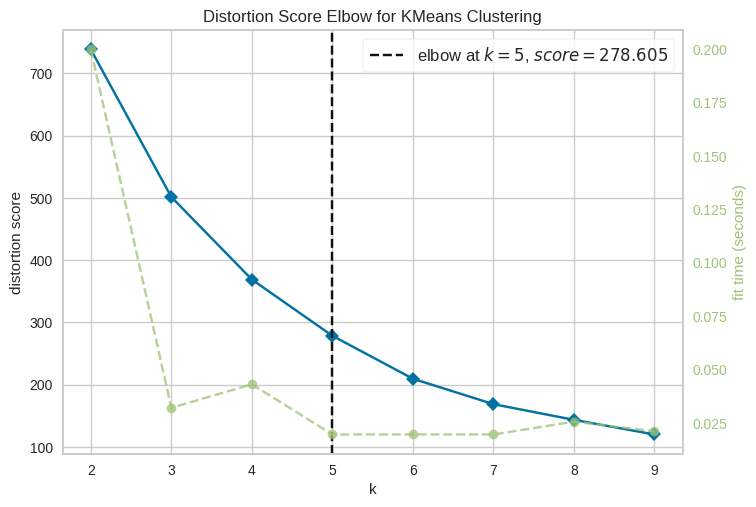

In [38]:
plot_elbow(range(2, 10), df_mean_scaled)

/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

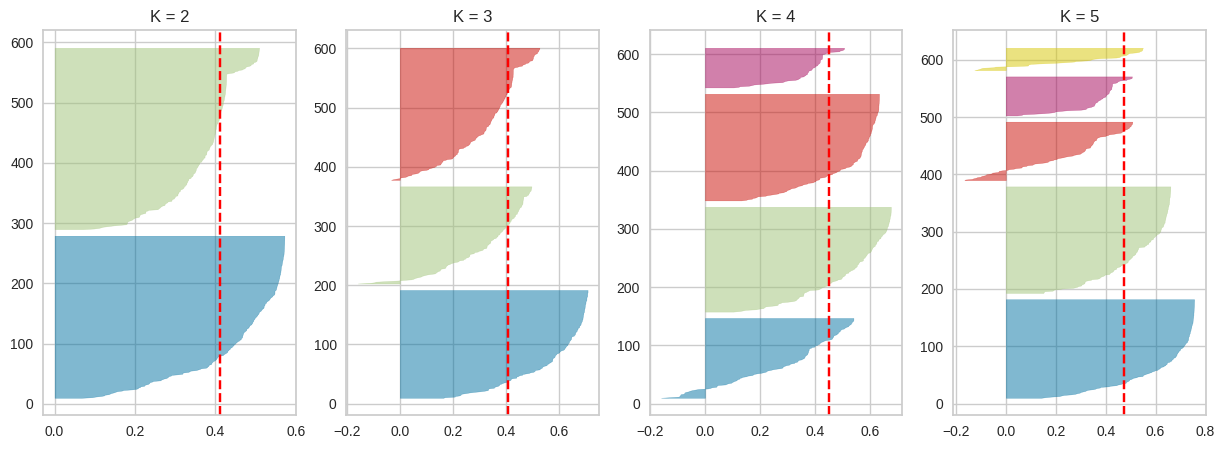

In [39]:
plot_sil(range(2, 6), df_mean_scaled)

In [40]:
n_clusters=  4
kmeans_mean = KMeans(n_clusters, random_state=0).fit(df_mean_scaled)

/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='Hbond', ylabel='Mean'>

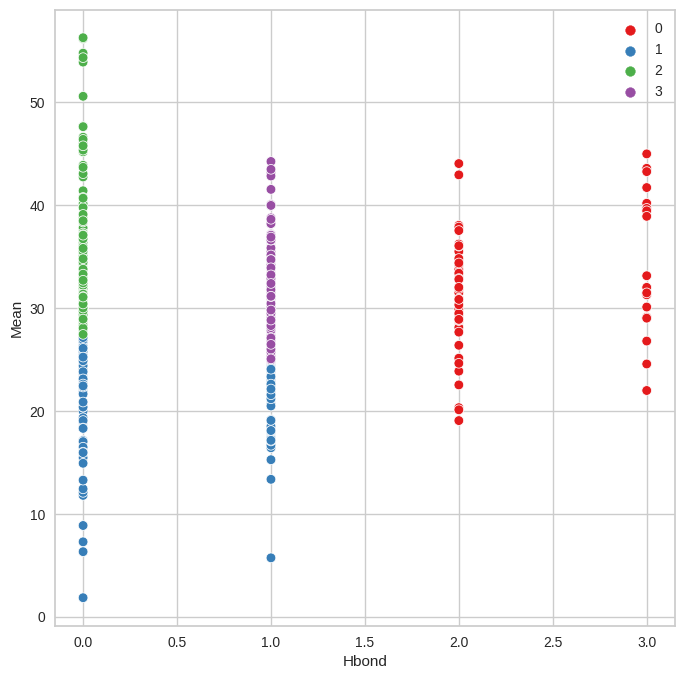

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x=df["Hbond"], y=df["Mean"], hue=kmeans_mean.labels_, ax=ax, palette="Set1")

#### Without Mean

In [42]:
df_no_mean = df.drop(columns=["Mean"])

In [43]:
scaler = StandardScaler()
no_mean_scaled = scaler.fit_transform(df_no_mean)
df_no_mean_scaled = pd.DataFrame(no_mean_scaled, columns=df_no_mean.columns, index=df_no_mean.index)

/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

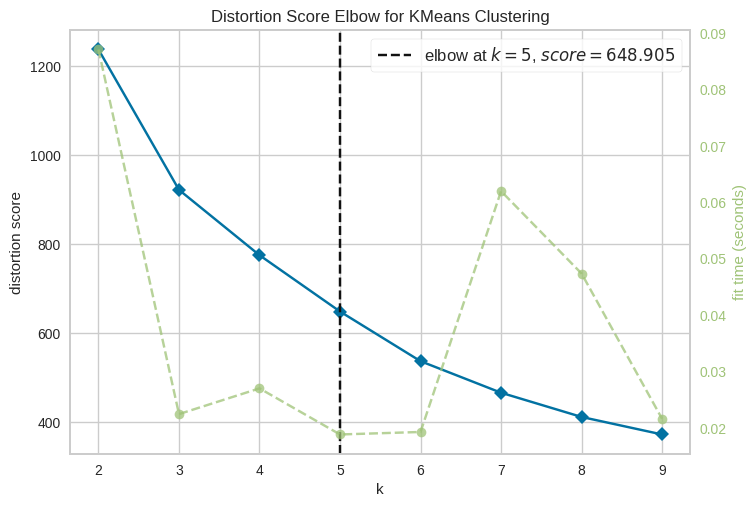

In [44]:
plot_elbow(range(2, 10), df_no_mean_scaled)

/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the w

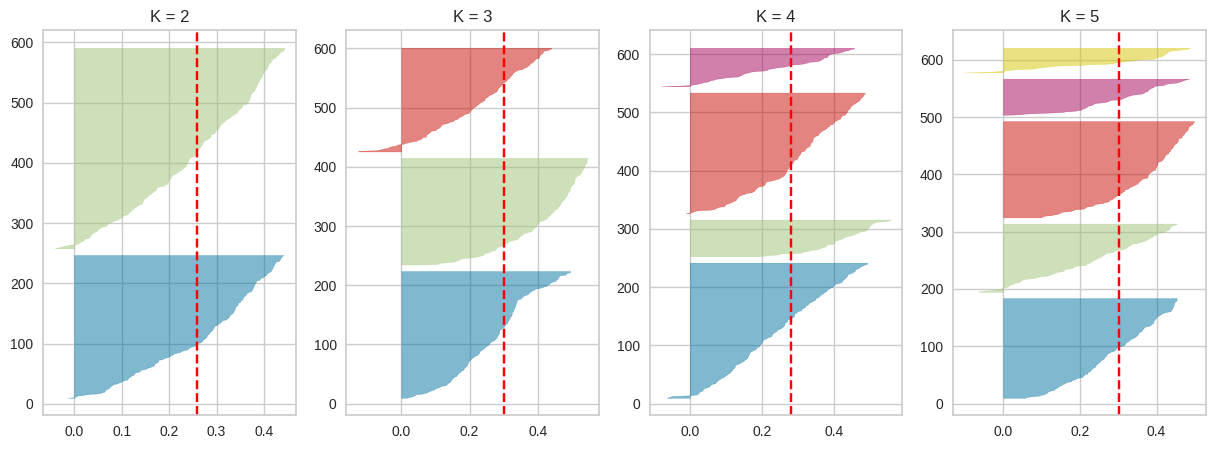

In [45]:
plot_sil(range(2, 6), df_no_mean_scaled)

In [46]:
n_clusters = 4
kmeans_no_mean = KMeans(n_clusters, random_state=0).fit(df_no_mean_scaled)

/home/hitesit/miniconda3/envs/CCDC/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: xlabel='Hbond', ylabel='Gold.PLP.Fitness'>

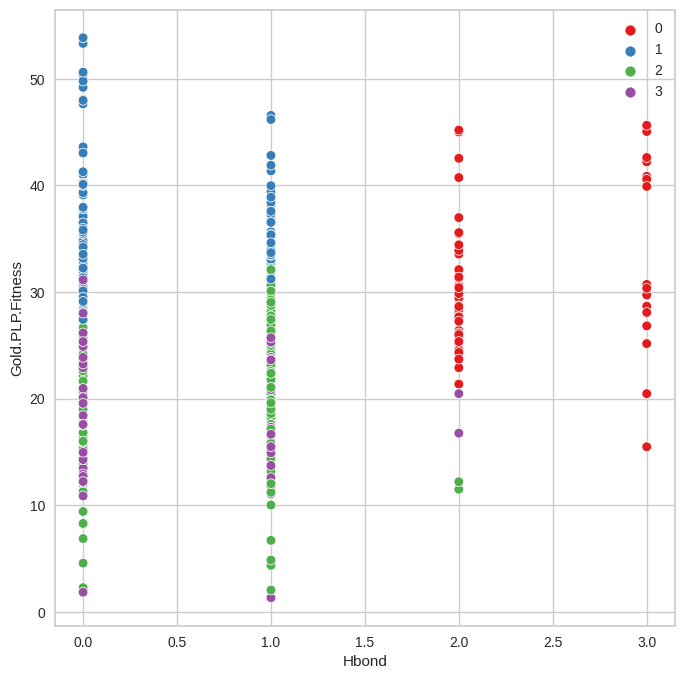

In [47]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x=df["Hbond"], y=df["Gold.PLP.Fitness"], hue=kmeans_no_mean.labels_, ax=ax, palette="Set1")

#### Compare

Text(0.5, 1.0, 'Separated')

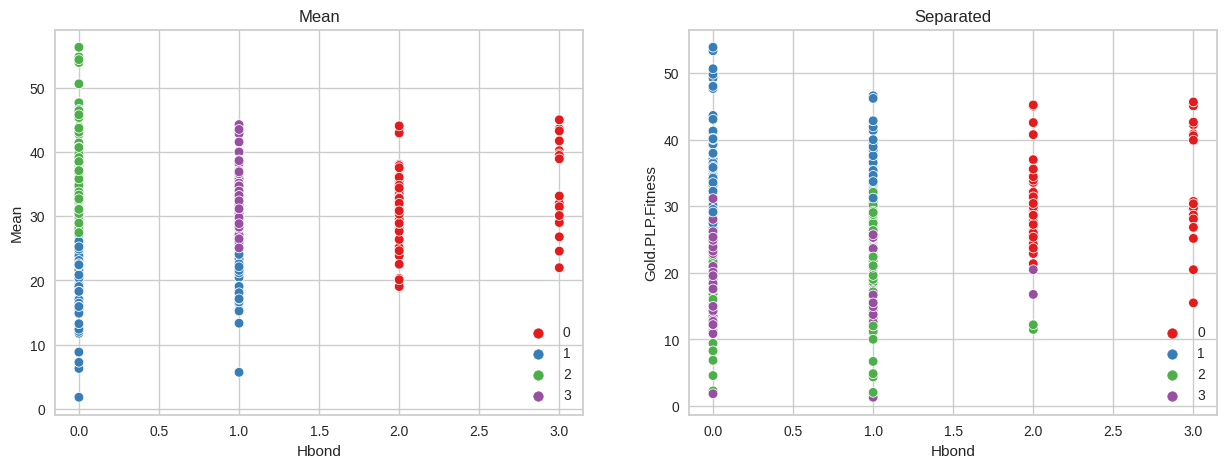

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=df["Hbond"], y=df["Mean"], hue=kmeans_mean.labels_, ax=axs[0], palette="Set1")
sns.scatterplot(x=df["Hbond"], y=df["Gold.PLP.Fitness"], hue=kmeans_no_mean.labels_, ax=axs[1], palette="Set1")

axs[0].set_title("Mean")
axs[1].set_title("Separated")

In [49]:
df["Cluster_from_mean"] = kmeans_mean.labels_
df["Cluster_from_no_mean"] = kmeans_no_mean.labels_

In [50]:
df.reset_index(inplace=True)

In [51]:
df.to_csv("docking_results_cluster.csv")